In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json 
import math
import scipy as sc
from itertools import islice
from random import sample
seed = 0

In [2]:
def get_network_mcf_json(fp: str, link_capacity: int) -> nx.Graph:

    with open(fp, mode='r') as file:
        in_data = json.load(file)

    G = nx.node_link_graph(in_data)
    nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), with_labels=True)
    nx.set_edge_attributes(G, link_capacity, "available_capacity")
    
    return G

In [3]:
from typing import List, Tuple 

def generate_demands(G: nx.Graph, total_flow: int) -> List[Tuple[int, int, int]]:
    #Initialize an empty list demands
    demands = []
    nodes = G.nodes()
    for i in range(total_flow):          #For each iteration in the range of total_flow:
        src, dst = np.random.choice(G.number_of_nodes(), size=(2,), replace=False)  #Randomly select two distinct nodes, src and dst, from the nodes in graph G
        rate = np.random.randint(100, 1000)
        demands.append((src, dst, rate))     #Append the tuple (src, dst) to the demands list

    return demands   #Return the demands list

In [4]:
def get_ksp(G: nx.Graph, n_paths: int, metric: str) -> dict[tuple[int, int]: list[int]]:
    
    ksp = {}                #Initialize an empty dictionary ksp
    for i in G.nodes:       #For each node i in the graph G:
        for j in G.nodes:   #For each node j in the graph G:
            if i < j:       #If i is less than j:
                            #Find the first n_paths shortest paths between nodes i and j in G using the specified metric
                paths = list(islice(nx.shortest_simple_paths(G, i, j, metric), n_paths))
                ksp[i, j] = paths
                ksp[j, i] = paths
                
    return ksp  #Return the dictionary ksp

In [5]:
def get_network_rwa_json(fp: str, n_wavelengths: int) -> nx.Graph:
    
    with open(fp, mode='r') as file:    #Open the file at path fp in read mode as file
        in_data = json.load(file)       #Load JSON data from file into data
   
    G = nx.node_link_graph(in_data)     #Convert data into a graph G using node-link format
    available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths

    for edge in G.edges():              #For each edge in G:
        available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8

    nx.set_edge_attributes(G, available_wavelengths, "available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    G.graph["n_wavelengths"] = n_wavelengths                                        #Set the graph attribute "n_wavelengths" in G to n_wavelengths

    return G                            #Return the graph G 

In [6]:
def get_network_rwa_json_dualband(fp: str, n_wavelengths: int) -> nx.Graph:
    
    with open(fp, mode='r') as file:    #Open the file at path fp in read mode as file
        in_data = json.load(file)       #Load JSON data from file into data
   
    G = nx.node_link_graph(in_data)     #Convert data into a graph G using node-link format
    c_available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths
    l_available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths

    for edge in G.edges():              #For each edge in G:
        c_available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8
        l_available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8

    nx.set_edge_attributes(G, c_available_wavelengths, "c_available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    nx.set_edge_attributes(G, l_available_wavelengths, "l_available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    G.graph["c_n_wavelengths"] = n_wavelengths                                        #Set the graph attribute "n_wavelengths" in G to n_wavelengths
    G.graph["l_n_wavelengths"] = n_wavelengths                                           #Set the graph attribute "n_wavelengths" in G to n_wavelengths

    return G                            #Return the graph G 

In [7]:
def sap_ff_rwa_variable(G: nx.Graph, demands: list, ksp: dict, dataPerWave: int, modReach: int) -> tuple[int, list]:
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    routed_demands = []
    num_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_regenerators_needed = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
                                                                    # Calculate the number of wavelengths required to satisfy the demand
        num_waves_needed = (rate // dataPerWave) + 1                # Ceiling division to ensure enough wavelengths
        
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []

            for wav in range(G.graph["n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                is_wavelength_free = True

                for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

                if len(available_waves) == num_waves_needed:   # If enough wavelengths are found, break out of the loop
                    break

            # Check if enough wavelengths were found to route the demand
            if len(available_waves) == num_waves_needed:
                for wav in available_waves:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["available_wavelengths"][wav] = 0
                        num_utilized_wavelengths += 1
                        if "length" in G[path[i]][path[i + 1]]:
                            num_regenerators_needed += G[path[i]][path[i + 1]]["length"] // modReach  # considering the node as a amplifier

                # Record the routed demand information
                n_routed_demands += 1
                routed_demands.append((src, dst, path, available_waves))
                break
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_regenerators_needed)
    print(routed_demands)
    return n_routed_demands, routed_demands


In [8]:
def allocateSpecial(G: nx.Graph, src: int, dst: int, rate: int, modTable: dict, band=None) -> tuple[tuple, int]:
    if band == "C-band":
        available_wavelengths = "c_available_wavelengths"
        n_wavelengths = "c_n_wavelengths"
    elif band == "L-band":
        available_wavelengths = "l_available_wavelengths"
        n_wavelengths = "l_n_wavelengths"
    else:
        available_wavelengths = "available_wavelengths"
        n_wavelengths = "n_wavelengths"
        band = "None"
    
    # Define a custom weight function for the shortest path algorithm
    def wavelength_weight(u, v, data):
        # Use the sum of available wavelengths as the weight
        if len(data[available_wavelengths])-sum(data[available_wavelengths]) == 96:
            return math.inf
        return len(data[available_wavelengths])-sum(data[available_wavelengths]) if available_wavelengths in data else float('inf')
    
    # Find the shortest path based on the custom weight
    path = nx.shortest_path(G, src, dst, weight=wavelength_weight)
    # find the shortest path using networkx library and basing on the metric in order to maximize the number of available wavelength on the link with less available wavelengths
    #path = nx.shortest_path(G, src, dst, weight='n_used_wavelengths')
    possible_mods = []
    longest_link = 0
    for i in range(len(path) - 1):
        if "length" in G[path[i]][path[i + 1]]:
            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
    for mod in modTable:
        if longest_link <= mod["Reach (km)"]:
            possible_mods.append(mod)
            
    available_waves = []
    for wav in range(G.graph[n_wavelengths]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
        is_wavelength_free = True

        for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
            # Check if the current wavelength is free along the entire path
            if G[path[i]][path[i + 1]][available_wavelengths][wav] == 0:
                is_wavelength_free = False
                break

        if is_wavelength_free:
            available_waves.append(wav)
    
    # Find the best modulation by choosing the one using the fewer number of wavelengths
    bestMod = None
    bestModWaves = math.inf
    for mod in possible_mods:
        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
        if modNeededWaves < bestModWaves or bestMod == None:
            bestMod = mod
            bestModWaves = modNeededWaves
    bestModWaves = int(bestModWaves) 

    utilized_wavelengths = 0
    if len(available_waves) >= bestModWaves:
        for wav in available_waves[:bestModWaves]:
            for i in range(len(path) - 1):
                # Assert that the wavelength is indeed free and then mark it as used
                assert G[path[i]][path[i + 1]][available_wavelengths][wav] == 1
                G[path[i]][path[i + 1]][available_wavelengths][wav] = 0
                utilized_wavelengths += 1
        if band == "None":
            return (src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"]) , utilized_wavelengths
        else:
            return (src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band) , utilized_wavelengths
    else:
        return None, None


In [9]:
# Define the data as a list of dictionaries
data_table = [
    {"Data Rate (Gb/s)": 800, "Bits/symbol (Gb/s)": 5.67, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 150},
    {"Data Rate (Gb/s)": 700, "Bits/symbol (Gb/s)": 5.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 400},
    {"Data Rate (Gb/s)": 600, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 700},
    {"Data Rate (Gb/s)": 500, "Bits/symbol (Gb/s)": 3.60, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 1300},
    {"Data Rate (Gb/s)": 400, "Bits/symbol (Gb/s)": 3.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 2500},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 2.39, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 4700},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 6.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 100},
    {"Data Rate (Gb/s)": 200, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 900},
    {"Data Rate (Gb/s)": 100, "Bits/symbol (Gb/s)": 2.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 3000},
]

# implement sap_ff_rwa_variable_mod that chooses the best modulation for each demand considering the reach of the modulation
def sap_ff_rwa_variable_mod(G: nx.Graph, demands: list, ksp: dict, modTable: list) -> tuple[int,list]:
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    routed_demands = []
    num_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of regenerators needed
    num_regenerators_needed = 0
    total_traffic = sum([rate for src, dst, rate in demands])
    total_routed_traffic = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
            
        
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []
            possible_mods = []
            longest_link = 0

            for i in range(len(path) - 1):
                if "length" in G[path[i]][path[i + 1]]:
                    longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
            for mod in modTable:
                if longest_link <= mod["Reach (km)"]:
                    possible_mods.append(mod)
            
            for wav in range(G.graph["n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                is_wavelength_free = True

                for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

            # Find the best modulation by choosing the one using the fewer number of wavelengths
            bestMod = None
            bestModWaves = math.inf
            for mod in possible_mods:
                modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                if modNeededWaves < bestModWaves or bestMod == None:
                    bestMod = mod
                    bestModWaves = modNeededWaves
            bestModWaves = int(bestModWaves)       
             
            # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
            if len(available_waves) >= bestModWaves:
                for wav in available_waves[:bestModWaves]:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["available_wavelengths"][wav] = 0
                        #G[path[i]][path[i + 1]]['n_used_wavelengths'] += 1
                        num_utilized_wavelengths += 1
                        #TODO regenerator if needed
                # Record the routed demand information
                n_routed_demands += 1
                total_routed_traffic += rate
                routed_demands.append((src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"]))
                break
            else: #impossible to route
                # try using a dedicated routine to allocate it
                specialRoute, nUsedWaves = allocateSpecial(G, src, dst, rate, modTable)
                if specialRoute != None:
                    n_routed_demands += 1
                    total_routed_traffic += rate
                    num_utilized_wavelengths += nUsedWaves
                    routed_demands.append(specialRoute)
                    break
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_regenerators_needed)
    print(f"We routed a total of {total_routed_traffic} Gbps of traffic out of {total_traffic} Gbps")
    print(routed_demands)
    return n_routed_demands, routed_demands

In [10]:
# adapting sap_ff_rwa_variable function to the dual band case such that if not enough available wavelengths are found in the c-band, the l-band is checked
def sap_ff_rwa_variable_dualband(G: nx.Graph, demands: list, ksp: dict, dataPerWave: int, modReach: int) -> tuple[int, list]:
    
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    n_c_routed_demands = 0
    n_l_routed_demands = 0
    routed_demands = []

    num_c_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_l_utilized_wavelengths = 0
    num_utilized_wavelengths = 0 
    num_regenerators_needed = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
                                                                    # Calculate the number of wavelengths required to satisfy the demand
        num_waves_needed = (rate // dataPerWave) + 1                # Ceiling division to ensure enough wavelengths
        
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []
                    
            # Attempt allocation in C-band
            for wav in range(G.graph["c_n_wavelengths"]):  # Check wavelengths in the C-band
                is_wavelength_free = True

                for i in range(len(path) - 1):  # Check wavelength continuity along the path
                    if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

                if len(available_waves) == num_waves_needed:  # If enough wavelengths are found, break out of the loop
                    break

            if len(available_waves) == num_waves_needed:  # If C-band allocation succeeded
                band = "C-band"
            else:  # Attempt allocation in L-band
                available_waves = []
                for wav in range(G.graph["l_n_wavelengths"]):
                    is_wavelength_free = True

                    for i in range(len(path) - 1):
                        if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 0:
                            is_wavelength_free = False
                            break

                    if is_wavelength_free:
                        available_waves.append(wav)

                    if len(available_waves) == num_waves_needed:  # If enough wavelengths are found, break out of the loop
                        break

                band = "L-band" if len(available_waves) == num_waves_needed else None

            # If enough wavelengths are found in either band, allocate them
            if len(available_waves) == num_waves_needed and band:
                for wav in available_waves:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert ((G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1) or
                                 (G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1))
                        if band == "C-band":
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1
                        elif band == "L-band":
                            G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                            num_l_utilized_wavelengths += 1
                        num_utilized_wavelengths += 1
                        if "length" in G[path[i]][path[i + 1]]:
                            num_regenerators_needed += G[path[i]][path[i + 1]]["length"] // modReach  # considering the node as an amplifier

                # Record the routed demand information
                n_c_routed_demands += 1 if band == "C-band" else n_l_routed_demands + 1
                n_routed_demands += 1
                routed_demands.append((src, dst, path, available_waves, band))
                break

    # Print summary
    print("Number of utilized wavelengths in C-band:", num_c_utilized_wavelengths)
    print("Number of utilized wavelengths in L-band:", num_l_utilized_wavelengths)
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_regenerators_needed)
    print(routed_demands)

    return n_routed_demands, routed_demands


In [19]:
def allocateSpecialLband(G: nx.Graph, src: int, dst: int, rate: int, modTable: dict, band='L-band') -> tuple[tuple, int]:

    available_wavelengths = "l_available_wavelengths"
    n_wavelengths = "l_n_wavelengths"
   
    # Define a custom weight function for the shortest path algorithm
    def wavelength_weight(u, v, data):
        utilized_wavelengths = len(data[available_wavelengths])-sum(data[available_wavelengths])
        
        if utilized_wavelengths == 96:
            return math.inf
        elif utilized_wavelengths > 0 and utilized_wavelengths < 96:
            return utilized_wavelengths
        return 99999 if available_wavelengths in data else float('inf') 
        # not infinite otherwise not used
        
    # Find the shortest path based on the custom weight
    path = nx.shortest_path(G, src, dst, weight=wavelength_weight)
    # find the shortest path using networkx library and basing on the metric in order to maximize the number of available wavelength on the link with less available wavelengths
    #path = nx.shortest_path(G, src, dst, weight='n_used_wavelengths')
    possible_mods = []
    longest_link = 0
    for i in range(len(path) - 1):
        if "length" in G[path[i]][path[i + 1]]:
            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
    for mod in modTable:
        if longest_link <= mod["Reach (km)"]:
            possible_mods.append(mod)
            
    available_waves = []
    for wav in range(G.graph[n_wavelengths]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
        is_wavelength_free = True

        for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
            # Check if the current wavelength is free along the entire path
            if G[path[i]][path[i + 1]][available_wavelengths][wav] == 0:
                is_wavelength_free = False
                break

        if is_wavelength_free:
            available_waves.append(wav)
    
    # Find the best modulation by choosing the one using the fewer number of wavelengths
    bestMod = None
    bestModWaves = math.inf
    for mod in possible_mods:
        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
        if modNeededWaves < bestModWaves or bestMod == None:
            bestMod = mod
            bestModWaves = modNeededWaves
    bestModWaves = int(bestModWaves) 

    utilized_wavelengths = 0
    if len(available_waves) >= bestModWaves:
        for wav in available_waves[:bestModWaves]:
            for i in range(len(path) - 1):
                # Assert that the wavelength is indeed free and then mark it as used
                assert G[path[i]][path[i + 1]][available_wavelengths][wav] == 1
                G[path[i]][path[i + 1]][available_wavelengths][wav] = 0
                utilized_wavelengths += 1
        if band == "None":
            return (src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"]) , utilized_wavelengths
        else:
            return (src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band) , utilized_wavelengths
    else:
        return None, None


In [17]:
# adapting sap_ff_rwa_variable function to the dual band case such that if not enough available wavelengths are found in the c-band, the l-band is checked
def sap_ff_rwa_variable_mod_dualband(G: nx.Graph, demands: list, ksp: dict, modTable: list) -> tuple[int, list]:
    
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    n_c_routed_demands = 0
    n_l_routed_demands = 0
    routed_demands = []

    num_c_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_l_utilized_wavelengths = 0
    num_utilized_wavelengths = 0 
    num_regenerators_needed = 0
    total_traffic = sum([rate for src, dst, rate in demands])
    total_routed_traffic_l = 0
    total_routed_traffic_c = 0
    
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
            
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []
            possible_mods = []
            longest_link = 0

            for i in range(len(path) - 1):
                if "length" in G[path[i]][path[i + 1]]:
                    longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
            for mod in modTable:
                if longest_link <= mod["Reach (km)"]:
                    possible_mods.append(mod)
            
            for wav in range(G.graph["c_n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                is_wavelength_free = True

                for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

            # Find the best modulation by choosing the one using the fewer number of wavelengths
            bestMod = None
            bestModWaves = math.inf
            for mod in possible_mods:
                modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                if modNeededWaves < bestModWaves or bestMod == None:
                    bestMod = mod
                    bestModWaves = modNeededWaves
            bestModWaves = int(bestModWaves)       
             
            # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
            if len(available_waves) >= bestModWaves:
                band = "C-band"
                for wav in available_waves[:bestModWaves]:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                        #G[path[i]][path[i + 1]]['n_used_wavelengths'] += 1
                        num_c_utilized_wavelengths += 1
                        #TODO regenerator if needed
                # Record the routed demand information
                n_c_routed_demands += 1
                total_routed_traffic_c += rate
                routed_demands.append((src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band))
                break
            else: #impossible to route
                band = "C-band"
                # try using a dedicated routine to allocate it
                specialRoute, nUsedWaves = allocateSpecial(G, src, dst, rate, modTable, band)
                if specialRoute != None:
                    n_c_routed_demands += 1
                    num_c_utilized_wavelengths += nUsedWaves
                    total_routed_traffic_c += rate
                    routed_demands.append(specialRoute)
                    break
                else:
                    band = "L-band"
                    break
        if band == "L-band":    # for L-band you first try to allocate on already existing L band link

            # First I try allocating on already existing L band link:
            specialRouteLband, nUsedWaves = allocateSpecialLband(G, src, dst, rate, modTable)
            if specialRouteLband != None:
                n_l_routed_demands += 1
                num_l_utilized_wavelengths += nUsedWaves
                total_routed_traffic_l += rate
                routed_demands.append(specialRouteLband)
                #break
            else:
                for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
                    available_waves = []
                    possible_mods = []
                    longest_link = 0

                    for i in range(len(path) - 1):
                        if "length" in G[path[i]][path[i + 1]]:
                            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
                    for mod in modTable:
                        if longest_link <= mod["Reach (km)"]:
                            possible_mods.append(mod)
                    
                    for wav in range(G.graph["l_n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                        is_wavelength_free = True

                        for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
                            # Check if the current wavelength is free along the entire path
                            if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 0:
                                is_wavelength_free = False
                                break

                        if is_wavelength_free:
                            available_waves.append(wav)

                    # Find the best modulation by choosing the one using the fewer number of wavelengths
                    bestMod = None
                    bestModWaves = math.inf
                    for mod in possible_mods:
                        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                        if modNeededWaves < bestModWaves or bestMod == None:
                            bestMod = mod
                            bestModWaves = modNeededWaves
                    bestModWaves = int(bestModWaves)       
                    
                    # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
                    if len(available_waves) >= bestModWaves:
                        for wav in available_waves[:bestModWaves]:
                            for i in range(len(path) - 1):
                                # Assert that the wavelength is indeed free and then mark it as used
                                assert G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1
                                G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                                #G[path[i]][path[i + 1]]['n_used_wavelengths'] += 1
                                num_l_utilized_wavelengths += 1
                                #TODO regenerator if needed
                        # Record the routed demand information
                        n_l_routed_demands += 1
                        total_routed_traffic_l += rate
                        routed_demands.append((src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band))
                        break
                
    # Print summary
    print("Number of utilized wavelengths in C-band:", num_c_utilized_wavelengths)
    print("Number of utilized wavelengths in L-band:", num_l_utilized_wavelengths)
    num_utilized_wavelengths = num_c_utilized_wavelengths + num_l_utilized_wavelengths
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_regenerators_needed)
    total_routed_traffic = total_routed_traffic_c + total_routed_traffic_l
    print(f"We routed a total of {total_routed_traffic} Gbps of traffic out of {total_traffic} Gbps")
    print(f'Of this, {total_routed_traffic_c} Gbps were routed in the C-band and {total_routed_traffic_l} Gbps in the L-band')
    n_routed_demands = n_c_routed_demands + n_l_routed_demands
    print(routed_demands)

    return n_routed_demands, routed_demands


In [12]:
def runHeuristic(G: nx.Graph, demands: list, num_spectrum: int, ksp_depth: int, plot_usage: bool, n_wavelengths: int, modTable: list, dualband: bool) -> tuple[int, bool]:
    ksp = get_ksp(G, ksp_depth, 'length')
    print(f'We generated {len(demands)} demands')
    
    if dualband:
        n_routed_demands, routed_demands = sap_ff_rwa_variable_mod_dualband(G, demands, ksp, modTable)
        edge_demand_map = {edge: {'C-band': [], 'L-band': []} for edge in G.edges}
    else:
        n_routed_demands, routed_demands = sap_ff_rwa_variable_mod(G, demands, ksp, modTable)
        edge_demand_map = {edge: [] for edge in G.edges}

    
    if plot_usage:
        if dualband:
            # Create separate figures for C-band and L-band
            plt_c_band = plt.figure(figsize=(16, 9))
            plt_l_band = plt.figure(figsize=(16, 9))
            pos = nx.get_node_attributes(G, "pos")

            # Draw base network for both bands
            plt.figure(plt_c_band.number)
            nx.draw(G, pos=pos, with_labels=True, node_color='skyblue')
            plt.title("C-band Usage")

            plt.figure(plt_l_band.number)
            nx.draw(G, pos=pos, with_labels=True, node_color='lightgreen')
            plt.title("L-band Usage")
        else: 
            plt_1 = plt.figure(figsize=(16, 9))
            nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)

        alpha_step = round(1 / n_wavelengths, 2)

    for demand_index, demand in enumerate(routed_demands):
        route = demand[2]
        band_used = demand[-1] if dualband else None  # Assuming the last element indicates the band used ('C' or 'L')
        route_el = list(zip(route, route[1:]))
        num_spectrum += len(route_el)  # Adjust for specific band usage if needed

        if dualband:
            for edge in route_el:
                if edge in edge_demand_map:
                    edge_demand_map[edge][band_used].append(demand_index)
                elif (edge[1], edge[0]) in edge_demand_map:
                    edge_demand_map[(edge[1], edge[0])][band_used].append(demand_index)
                else:
                    edge_demand_map[edge] = {'C-band': [], 'L-band': []}
                    edge_demand_map[edge][band_used].append(demand_index)
        else:
            for edge in route_el:
                if edge in edge_demand_map:
                    edge_demand_map[edge].append(demand_index)
                elif (edge[1], edge[0]) in edge_demand_map:
                    edge_demand_map[(edge[1], edge[0])].append(demand_index)
                else:
                    edge_demand_map[edge] = [demand_index]
        
    
        if plot_usage:
            if dualband:
                # Plot edges in the respective band's graph
                if band_used == 'C-band':
                    plt.figure(plt_c_band.number)
                    nx.draw_networkx_edges(G, pos=pos, edgelist=route_el, width=10, alpha=alpha_step*(len(demand[-3])), edge_color='blue')
                elif band_used == 'L-band':
                    plt.figure(plt_l_band.number)
                    nx.draw_networkx_edges(G, pos=pos, edgelist=route_el, width=10, alpha=alpha_step*(len(demand[-3])), edge_color='green')
            else:
                nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, "pos"), edgelist=route_el, width=10, alpha=alpha_step, edge_color='red')
                #label every edge with all indexes of demands it is carrying

    # if plot_usage:
    #     if dualband:
    #         # Generate labels for edges in C-band and L-band
    #         c_band_labels = {
    #             edge: ','.join(map(str, indexes['C-band'])) for edge, indexes in edge_demand_map.items() if indexes['C-band']
    #         }
    #         l_band_labels = {
    #             edge: ','.join(map(str, indexes['L-band'])) for edge, indexes in edge_demand_map.items() if indexes['L-band']
    #         }

    #         # Add edge labels to the respective plots
    #         plt.figure(plt_c_band.number)
    #         nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=c_band_labels, font_size=11, font_weight='bold') #

    #         plt.figure(plt_l_band.number)
    #         nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=l_band_labels, font_size=11, font_weight='bold')
    #     else:
    #         edge_labels = {edge: ','.join(map(str, indexes)) for edge, indexes in edge_demand_map.items() if indexes}
    #         nx.draw_networkx_edge_labels(G, pos=nx.get_node_attributes(G, 'pos'), edge_labels=edge_labels, font_size=11, font_weight='bold')

    # Show as label on each edge the percentage of wavelength occupied on that edge in each band
    # The usage is calculated as the number of occupied wavelengths ("X_n_available" == 0) divided by the total number of wavelengths on each band of an edge
    if plot_usage:
        if dualband:
            for edge in G.edges:
                if edge in edge_demand_map:
                    c_band_usage = 1 - np.sum(G[edge[0]][edge[1]]['c_available_wavelengths']) / n_wavelengths
                    l_band_usage = 1 - np.sum(G[edge[0]][edge[1]]['l_available_wavelengths']) / n_wavelengths
                    c_band_label = f'C-band: {c_band_usage:.2%}'
                    l_band_label = f'L-band: {l_band_usage:.2%}'
                    plt.figure(plt_c_band.number)
                    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={edge: c_band_label}, font_size=11, font_weight='bold')
                    plt.figure(plt_l_band.number)
                    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={edge: l_band_label}, font_size=11, font_weight='bold')
        else:
            for edge in G.edges:
                if edge in edge_demand_map:
                    usage = 1 - np.sum(G[edge[0]][edge[1]]['available_wavelengths']) / n_wavelengths
                    label = f'Usage: {usage:.2%}'
                    nx.draw_networkx_edge_labels(G, pos=nx.get_node_attributes(G, 'pos'), edge_labels={edge: label}, font_size=11, font_weight='bold')
    

    #print(f"Spectrum occupation is: {num_spectrum}")
    if n_routed_demands == len(demands):
        print("All demands were routed")
        return num_spectrum, True
    else:
        print(f"Only {n_routed_demands} demands were routed")
        return num_spectrum, False


In [13]:
# Define the data as a list of dictionaries
data_table = [
    {"Data Rate (Gb/s)": 800, "Bits/symbol (Gb/s)": 5.67, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 150},
    {"Data Rate (Gb/s)": 700, "Bits/symbol (Gb/s)": 5.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 400},
    {"Data Rate (Gb/s)": 600, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 700},
    {"Data Rate (Gb/s)": 500, "Bits/symbol (Gb/s)": 3.60, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 1300},
    {"Data Rate (Gb/s)": 400, "Bits/symbol (Gb/s)": 3.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 2500},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 2.39, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 4700},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 6.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 100},
    {"Data Rate (Gb/s)": 200, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 900},
    {"Data Rate (Gb/s)": 100, "Bits/symbol (Gb/s)": 2.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 3000},
]

def set_parameters(mod):
    """
    Set variables based on the selected mode (mod).
    Args:
    mod (int): The index of the desired mode (0 to 8).
    
    Returns:
    tuple: datarate, entropy, spacing, and reach for the selected mode.
    """
    if 0 <= mod < len(data_table):
        entry = data_table[mod]
        datarate = entry["Data Rate (Gb/s)"]
        entropy = entry["Bits/symbol (Gb/s)"]
        spacing = entry["Channel spacing (Δf) (GHz)"]
        reach = entry["Reach (km)"]
        return datarate, entropy, spacing, reach
    else:
        raise ValueError("Invalid mode selected. Please choose a value between 0 and 8.")

# Example: User chooses a mode (e.g., mod = 1)
# mod = 7# Change this value to set a different mode

# Get the parameters for the selected mode and assign to variables
# datarate, entropy, spacing, reach = set_parameters(mod)

# Display the parameters
# print(f"Datarate: {datarate} Gb/s")
# print(f"Entropy: {entropy} Bits/symbol")
# print(f"Channel Spacing: {spacing} GHz")
# print(f"Reach: {reach} km")


Datarate: 200 Gb/s
Channel Spacing: 50 GHz
Reach: 900 km

TM: [(1, 0, 210), (10, 1, 656), (6, 0, 873), (8, 6, 593), (1, 8, 503), (6, 8, 332), (7, 2, 625), (10, 0, 707), (11, 9, 302), (0, 10, 652), (8, 5, 180), (0, 7, 535), (1, 9, 652), (3, 5, 287), (10, 2, 133), (10, 3, 846), (8, 6, 523), (10, 6, 119), (8, 6, 180), (11, 4, 297), (0, 7, 943), (8, 7, 577), (0, 8, 463), (0, 3, 874), (8, 2, 912), (1, 3, 546), (2, 3, 923), (2, 1, 905), (5, 7, 115), (0, 10, 363), (2, 9, 715), (2, 10, 136), (6, 2, 946), (1, 5, 484), (6, 5, 602), (1, 8, 955), (8, 5, 484), (10, 3, 402), (8, 3, 440), (9, 2, 282), (3, 5, 431), (9, 4, 745), (7, 8, 771), (3, 9, 852), (9, 10, 676), (4, 3, 740), (11, 6, 866), (6, 1, 487), (5, 3, 133), (2, 5, 967), (10, 5, 919), (8, 2, 119), (8, 0, 303), (7, 8, 535), (3, 8, 640), (11, 3, 618), (4, 6, 178), (10, 1, 562), (5, 1, 602), (5, 11, 657), (5, 10, 756), (10, 6, 741), (4, 1, 606), (7, 10, 903), (2, 3, 867), (10, 4, 856), (0, 1, 651), (11, 3, 183), (8, 9, 822), (11, 3, 605), (6, 

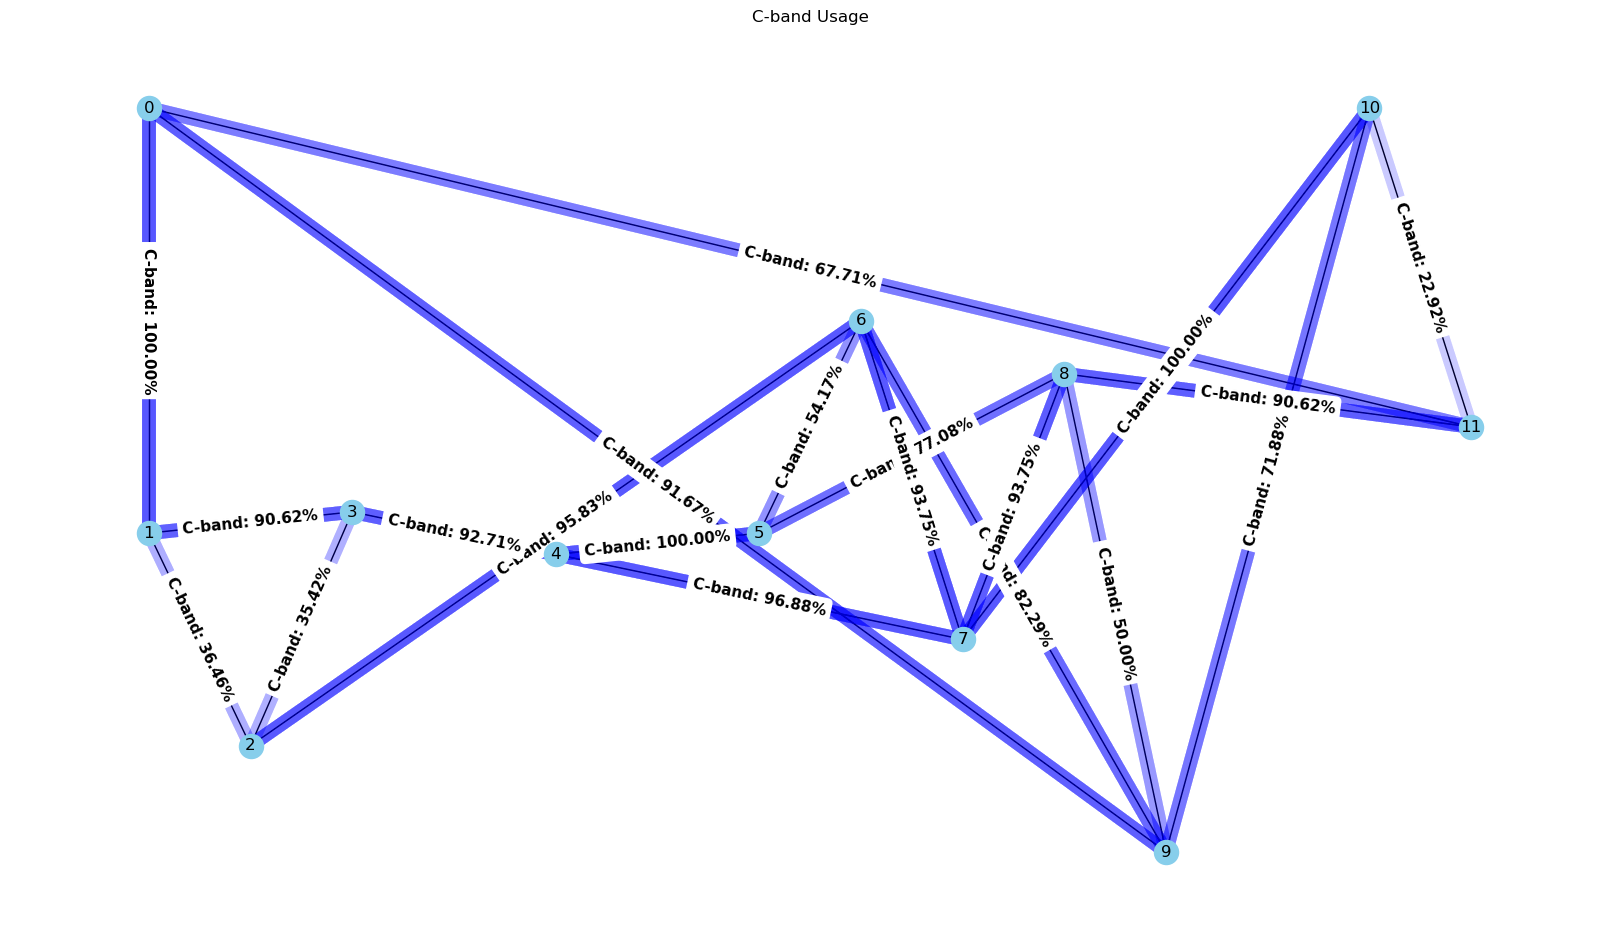

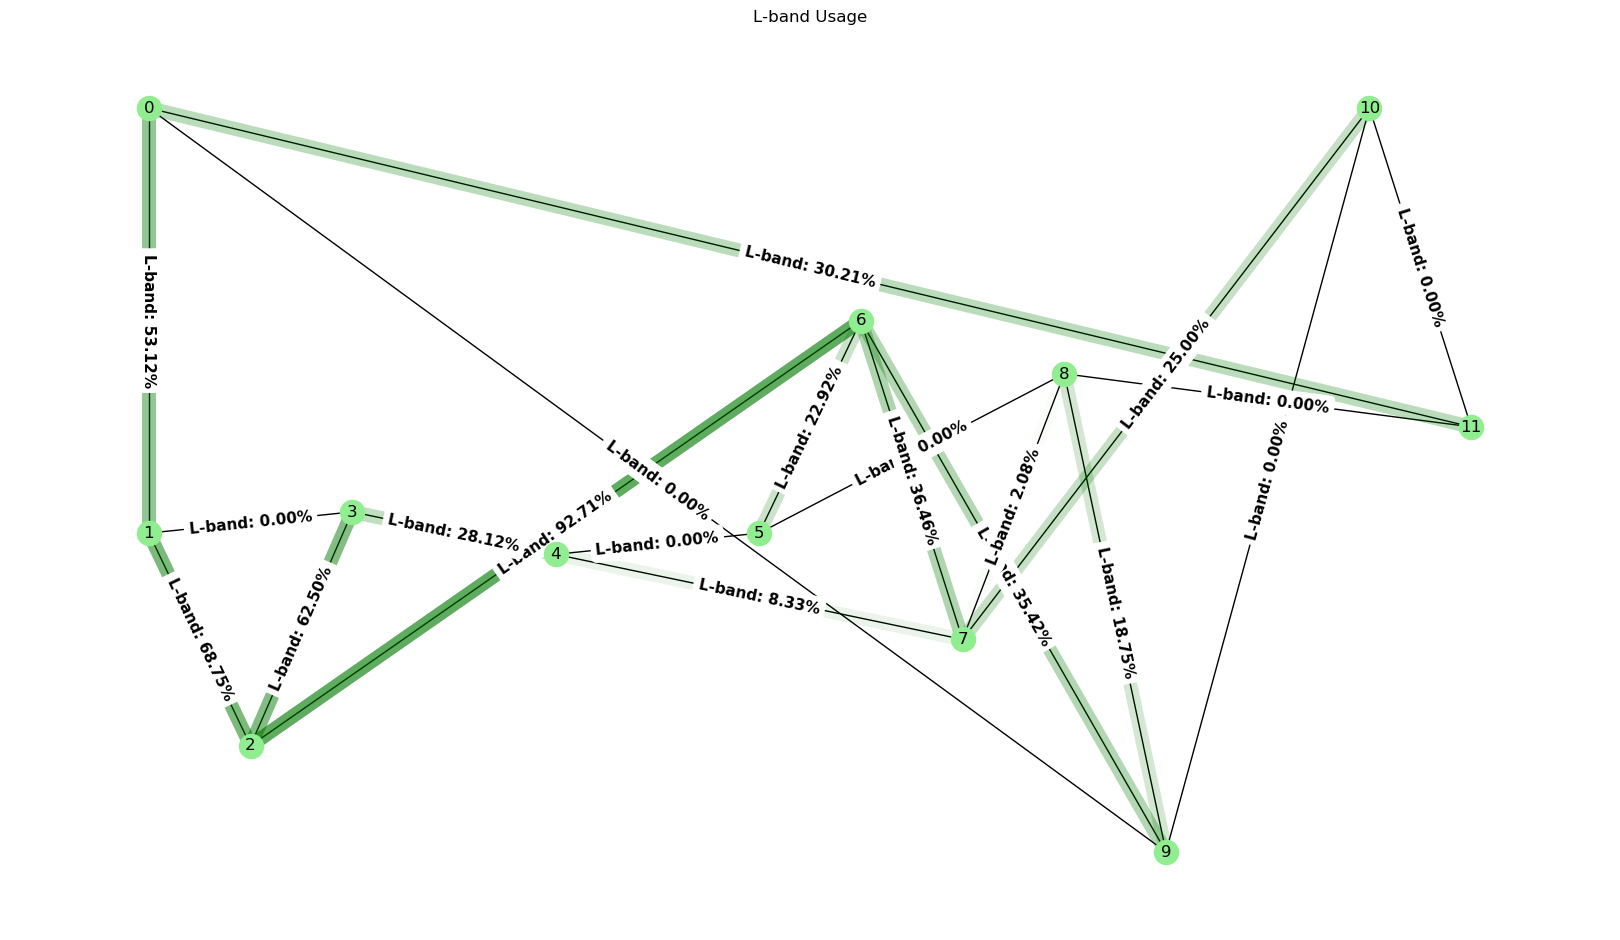

In [21]:
from ortools.linear_solver import pywraplp

channelPerBand = 96 #at 50GHz

biggertopology = True # True = continental, False = national
dualband = True # Change this value to set the dualband mode
n_ksp = 3 # Change this value to set the number of shortest paths
mod = 7 # Change this value to set a different mode
plot_usage = True
# Get the parameters for the selected mode and assign to variables
datarate, entropy, spacing, reach = set_parameters(mod)

if dualband:
    if biggertopology:
        G = get_network_rwa_json_dualband("continental.json", channelPerBand)
    else:
        G = get_network_rwa_json_dualband("national.json", channelPerBand)    
else:
    if biggertopology:
        G = get_network_rwa_json("continental.json", channelPerBand)   
    else:
        G = get_network_rwa_json("national.json", channelPerBand)
    
# nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)

# Display the parameters
print(f"Datarate: {datarate} Gb/s")
print(f"Channel Spacing: {spacing} GHz")
print(f"Reach: {reach} km")

TM = generate_demands(G, 300)
for edge in G.edges:
    G.edges[edge]["capacity"] = (channelPerBand * 50 / spacing) * datarate 
    G.edges[edge]["n_wavelength"] = channelPerBand * 50 / spacing

#print(G)
print(f"\nTM: {TM}")
spectrum, all_routed = runHeuristic(G, TM, 
                                    num_spectrum=0, 
                                    ksp_depth=n_ksp,
                                    plot_usage=plot_usage, 
                                    n_wavelengths=channelPerBand,
                                    modTable=data_table,
                                    dualband=dualband)

for edge in G.edges:
    if dualband:
        print(f'\nLink: {edge}\nLength: {G.edges[edge].get("length")}\nC-Band wavelength utilization: {G.edges[edge]["c_available_wavelengths"]}\nL-Band wavelength utilization: {G.edges[edge]["l_available_wavelengths"]}')
    else:
        print(f'\nLink: {edge}\nLength: {G.edges[edge].get("length")}\nWavelength utilization: {G.edges[edge]["available_wavelengths"]}')
